<a href="https://colab.research.google.com/github/OraMoyal26/bacteria_dimensions/blob/main/run_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## data needed for this code: images folder(JPG)

## Install necessary dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install -U -q "tensorflow>=2.9.2" "tf-models-official"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 74.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 88.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 32.8 MB/s eta 0:0

In [ ]:
!pip install numpy==1.23

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 27.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.0 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.23.0 which is incompatible.
tensorflow 2.16.1 requires numpy<2.0.0,>=1.23.5; python_version <= "3.11", but you have numpy 1.23.0 which is incompatible.


## Import required libraries

In [ ]:
import os
import io
import pprint
import tempfile
import matplotlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

import cv2

import glob

from PIL import Image
from six import BytesIO
from IPython import display
from urllib.request import urlopen



## Import required libraries from tensorflow models

In [ ]:
import orbit
import tensorflow_models as tfm

from official.core import exp_factory
from official.core import config_definitions as cfg
from official.vision.serving import export_saved_model_lib
from official.vision.ops.preprocess_ops import normalize_image
from official.vision.ops.preprocess_ops import resize_and_crop_image
from official.vision.utils.object_detection import visualization_utils
from official.vision.dataloaders.tf_example_decoder import TfExampleDecoder

pp = pprint.PrettyPrinter(indent=4) # Set Pretty Print Indentation
print(tf.__version__) # Check the version of tensorflow used

%matplotlib inline

2.16.1


In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=1.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



def build_inputs_for_object_detection(image, input_image_size):
  """Builds Object Detection model inputs for serving."""
  image, _ = resize_and_crop_image(
      image,
      input_image_size,
      padded_size=input_image_size,
      aug_scale_min=1.0,
      aug_scale_max=1.0)
  return image

In [ ]:
export_dir ='/content/gdrive/MyDrive/bacteria cells/exported model'

Loading Model:

In [ ]:
imported = tf.saved_model.load(export_dir)
model_fn = imported.signatures['serving_default']

Loading Data:

In [ ]:

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        img = cv2.imread(file_path)
        if img is not None:
            images.append(img)
    return np.array(images)


folder_path = '/content/gdrive/MyDrive/bacteria cells/test json/test'
image_array = load_images_from_folder(folder_path)


## Creating a csv file to save the labels

In [ ]:

df = pd.DataFrame(columns=['image', 'xmin', 'ymin', 'xmax', 'ymax', 'label'])

## Visualize predictions

(204, 6)


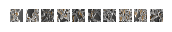

In [ ]:
HEIGHT, WIDTH = 640, 640

input_image_size = (HEIGHT, WIDTH)
max_boxes_to_draw=50
plt.figure(figsize=(20, 20))
min_score_thresh = 0.5 # Change minimum score for threshold to see all bounding boxes confidences.

category_index = {1: {'id': 1, 'name': 'Bacterial-Cells'}
                  }

for i, serialized_example in enumerate(image_array):
  plt.subplot(100,100, i+1)

  #Resize the image to the model
  target_size = (640, 640)  # Set your desired size
  resized_image = cv2.resize(image_array[i], target_size)
  input_tensor = tf.convert_to_tensor(resized_image)
  input_tensor = input_tensor[tf.newaxis, ...]
  from google.colab.patches import cv2_imshow
  #cv2_imshow(image)
  #print(input_tensor)

  # Prediction of the image in the model
  output_dict = imported.signatures['serving_default'](input_tensor)

  #Processing the outputs from the model
  output_classes = output_dict['detection_classes'].numpy()
  output_scores = output_dict['detection_scores'].numpy()
  output_boxes = output_dict['detection_boxes'].numpy()

  #Saving the original image
  pic = Image.fromarray(resized_image)
  pic.save('/content/gdrive/MyDrive/bacteria cells/test json/'+str(i)+'.jpg')


  visualization_utils.visualize_boxes_and_labels_on_image_array(
      resized_image,
      output_dict['detection_boxes'][0].numpy(),
      output_dict['detection_classes'][0].numpy().astype(int),
      output_dict['detection_scores'][0].numpy(),
      category_index=category_index,
      use_normalized_coordinates=False,
      max_boxes_to_draw=50,
      min_score_thresh=min_score_thresh,
      agnostic_mode=True,
      instance_masks=None,
      line_thickness=1)
  line=(output_dict['detection_boxes'][0].numpy())
  #Save the labels to the CSV file
  lst = line.tolist()
  for j in lst:
    if(j[0]!=0 and j[1]!=0 and j[2]!=0 and j[3]!=0 ):
      df.loc[len(df),:]= [str(i)+'.jpg', j[0], j[1] ,j[2] ,j[3] ,"1" ]



  #Save the image with the annotations from the model
  pic2 = Image.fromarray(resized_image)
  pic2.save('/content/gdrive/MyDrive/BacterialCells/' +str(i)+ '.jpg')

  plt.imshow(resized_image)
  plt.axis('off')

  #print(df.shape)

print(df.shape)
plt.show()

In [ ]:
df.to_csv('/content/gdrive/MyDrive/BacterialCells/annotation.csv')